## Lab 3 Demo - How to write a dataset for images

In this lab demo we will show you how to write a dataset for loading images. This will be really useful for your assignment.

The cell below loads up a very small dataset containing images of 4 different types of animals. The image files belonging to the same animal type are stored via the name for the animal. Please see the structure below:

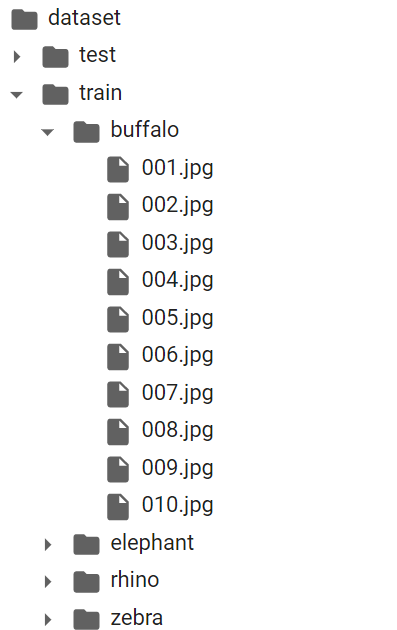


The cell below loads the data

In [1]:
!wget https://ashwhall.github.io/download/african-wildlife-small/dataset.zip
!mkdir -p dataset
!unzip -qu dataset.zip -d dataset
!rm dataset.zip

--2023-03-16 03:34:15--  https://ashwhall.github.io/download/african-wildlife-small/dataset.zip
Resolving ashwhall.github.io (ashwhall.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to ashwhall.github.io (ashwhall.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13915544 (13M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  13.27M  --.-KB/s    in 0.1s    

2023-03-16 03:34:16 (96.6 MB/s) - ‘dataset.zip’ saved [13915544/13915544]



The cell below loads the necessary libraries

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


### Loading images eagerly
The following data set loads the images eagerly. Namely in the *__init__* function all the images are loaded and stored in the *self.images* list.

In [3]:
class ImageDatasetEagerLoad(Dataset):

  # root_dir specifies the root directory where your images should be stored.
  def __init__(self, root_dir):
   
    self.root_dir = root_dir

    # This lists the sub-directory names from the root directory which will
    # be our class names
    self.classes = os.listdir(root_dir)

    self.images = []
    self.labels = []
    class_paths = []

    # This loop stores each sub-directory name inside the class_paths list
    for class_dir in self.classes:
        class_paths.append(os.path.join(root_dir, class_dir))

    # This loops through each sub-directory
    for i, class_path in enumerate(class_paths):

      # This loops through each image file within each sub-directory (one for 
      # each class)
      for image_file in os.listdir(class_path):
          # We append the image_file name after the sub-directory class_path
          image_path = os.path.join(class_path, image_file)
          # open the image using the PIL library function
          image = Image.open(image_path)
          # convert the PIL image into a pyTorch tensor
          image = torch.Tensor(np.array(image))

          # append the image into the end images list
          self.images.append(image)

          # append the class index into the labels list
          self.labels.append(i)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    return image, label
  
  # function used to return class name in text form when given the class index
  def get_class_name(self, class_idx):
    return self.classes[class_idx]

  # function used to return the list of all classes
  def get_all_class_names(self):
    return self.classes


Lets now take a look at the shape of the image and also the class label information. Notice the shape of the input. There are a few things to note.
The image size is irregular and also the channels is the in the 3rd dimension. 
Both of these facts will cause us problems in the future. We will address them later.

In [4]:
eagerDataset = ImageDatasetEagerLoad('dataset/train')
input, label = eagerDataset[0]
print(input.shape)
print(label)
print(eagerDataset.get_class_name(label))
print(eagerDataset.get_all_class_names())


torch.Size([384, 256, 3])
0
zebra
['zebra', 'elephant', 'rhino', 'buffalo']


Lets visualize the first image in the dataset.

torch.Size([384, 256, 3])


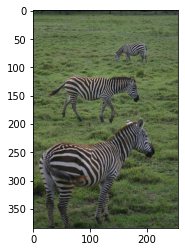

In [5]:
import matplotlib.pyplot as plt

input, label = eagerDataset[0]
print(input.shape)
img = input.numpy()
img -= np.min(img)
img /= (np.max(img) - np.min(img))

plt.imshow(img)

### Lazy data loading

Lets now think how we can load the images in a lazy manner so we only load them when they are actually used instead of eagerly loading the data into lists. We call this lazy data loading. The code block below performs the lazy data loading.

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ImageDatasetLazyLoad(Dataset):

  # root_dir specifies the root directory where your images should be stored.
  def __init__(self, root_dir):
  
    self.root_dir = root_dir
    
    # This lists the sub-directory names from the root directory which will
    # be our class names
    self.classes = os.listdir(root_dir)
    self.images = []
    self.labels = []
    class_paths = []

    # This loop stores each sub-directory name inside the class_paths list
    for class_dir in self.classes:
        class_paths.append(os.path.join(root_dir, class_dir))

    # This loops through each sub-directory
    for i, class_path in enumerate(class_paths):

      # This loops through each image file within each sub-directory (one for 
      # each class)
      for image_file in os.listdir(class_path):
          # We append the image_file name after the sub-directory class_path
          image_path = os.path.join(class_path, image_file)

          # Here instead of appending the image itself we append the path to 
          # find the image
          self.images.append(image_path)
          self.labels.append(i)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = self.images[idx]
    label = self.labels[idx]

    # We load the image and convert it into a tensor in the two lines below
    image = Image.open(image_path)
    image = torch.Tensor(np.array(image))

    return image, label
  
  def get_class_name(self, class_idx):
    return self.classes[class_idx]

  def get_all_class_names(self):
    return self.classes

Lets test this lazy dataset. We should get the same output

In [ ]:
lazyDataset = ImageDatasetLazyLoad('dataset/train')
input, label = lazyDataset[0]
print(input.shape)
print(label)
print(eagerDataset.get_class_name(label))
print(eagerDataset.get_all_class_names())

torch.Size([192, 256, 3])
0
zebra
['zebra', 'rhino', 'elephant', 'buffalo']


Lets try to get a batch of this data and print its shape.
It does not work! This is because each image has different dimensions. Everything in a batch must have uniform size. We need to write a new dataset to address this problem.

In [ ]:
train_dataloader = DataLoader(lazyDataset, batch_size=8, shuffle=True)
batch = next(iter(train_dataloader))
print(batch.shape)

RuntimeError: ignored

### The lazy dataset that transforms images to the same size.
In this cell we will write a dataset that uses the transform function to make all images the same size.

In [6]:
import torchvision.transforms as transforms

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ImageDatasetLazyLoadTransform(Dataset):

   # root_dir specifies the root directory where your images should be stored.
   # The train_mode parameter is a boolean that tells us if this dataset is the
   # the training dataset. Since sometimes you do different transformations
   # depending on if you are in train_mode or eval mode. For example you should
   # only do horizontal flip augmentation if you are in training mode.
  def __init__(self, root_dir, train_mode):
  
    self.root_dir = root_dir
    
    # This lists the sub-directory names from the root directory which will
    # be our class names
    self.classes = os.listdir(root_dir)
    self.images = []
    self.labels = []
    class_paths = []

    # This loop stores each sub-directory name inside the class_paths list
    for class_dir in self.classes:
        class_paths.append(os.path.join(root_dir, class_dir))

    # This loops through each sub-directory
    for i, class_path in enumerate(class_paths):

      # This loops through each image file within each sub-directory (one for 
      # each class)
      for image_file in os.listdir(class_path):
          # We append the image_file name after the sub-directory class_path
          image_path = os.path.join(class_path, image_file)

          # Here instead of appending the image itself we append the path to 
          # find the image
          self.images.append(image_path)
          self.labels.append(i)

    # We are going to apply two transformations.
    # The first transformation resizes the image so the shortest side becomes 224
    # in length. But this still means the long side is likely to be greater than 224
    # in length. Hence we use random crop to take a 224 x 224 crop from a random 
    # location in the resized image thus guaranteeing it will be of size 224 x 224.
    # Note taking a "random crop" is only a good idea for training. When you are
    # in eval mode you should take a center crop instead. Since the center usually
    # has more information.
    self.train_transforms = transforms.Compose([
                                transforms.Resize(224),
                                transforms.RandomCrop(224)
                            ])
    self.train_mode = train_mode

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = self.images[idx]
    label = self.labels[idx]

    image = Image.open(image_path)
    image = torch.Tensor(np.array(image))

    # We need to move the dimensions around from [H, W, C] to [C, H, W]
    # since the transformation function expects the images to have
    # shape [C, H, W] also 2D CNN layers expect images to be in this shape 
    # as well.
    image = image.permute(2,0,1)

    # Here we apply the transformations to the pytorch image tensor
    if self.train_mode:
      image = self.train_transforms(image)

    return image, label
  
  def get_class_name(self, class_idx):
    return self.classes[class_idx]

  def get_all_class_names(self):
    return self.classes


Now when we use the dataloader to get a batch it works! This is because the each image has the same shape hence we can batch it correctly.

In [7]:
lazyDatasetTransform = ImageDatasetLazyLoadTransform('dataset/train', True)
print(lazyDatasetTransform[0][0].shape)
print(len(lazyDatasetTransform))
train_dataloader = DataLoader(lazyDatasetTransform, batch_size=8, shuffle=True)
batch = next(iter(train_dataloader))
input, label = batch
print(input.shape)

torch.Size([3, 224, 224])
40
torch.Size([8, 3, 224, 224])


The code below can be used to display a batch of images along with their corresponding class names.

In [8]:
def plot_some_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    num_imgs = min(15, len(images))
    for i in range(num_imgs):
        # Select a subplot in a 3x5 grid
        ax = plt.subplot(3, 5, i + 1)
        img = images[i]
        # Transpose to expected format
        img = np.transpose(img, (1, 2, 0))
        # Normalise images to [0, 1]
        img -= np.min(img)
        img /= (np.max(img) - np.min(img))
        # Plot the image with its class label
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")


Now lets use the above function to display our batch of images!

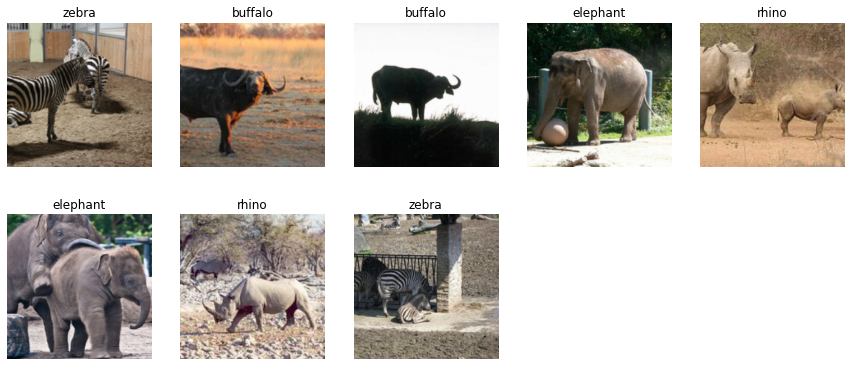

In [9]:
# Take a batch of images and labels
batch_images, batch_labels = next(iter(train_dataloader))

# Plot!
plot_some_images(batch_images.numpy(), batch_labels, lazyDatasetTransform.get_all_class_names())

Now lets write a simple 2D CNN model for this data. The code below does not work quite right? What do you think the problem are?

Here are the problems with it:

1.   The number of input channels for the 2nd 2D CNN does not match the number of output channels for the 1st layer.
2.   The number of channels specified for the 1st BatchNorm is not correct.
3.   The linear layer has the wrong number of input features.
4.   The number of outputs for the linear layer is wrong, we are doing 4 class classification.
5.   Our images have RGB channels so the 1st CNN should take 3 channels as input.



In [10]:
class CNNModel(nn.Module):   
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # Defining another 2D convolution layer
            nn.Conv2d(10, 10, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(10, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Lets write the correct model now. But first lets print out the shape of the output of the CNN layers. This way we will know the number of input features we should give to the linear layer.

In [11]:
import torch.nn as nn

class CNNModel(nn.Module):   
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),

            # Defining another 2D convolution layer
            nn.Conv2d(5, 10, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

      #  self.linear_layers = nn.Sequential(
      #      nn.Linear(??, 4)
      #  )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        print(x.shape)
        # x = x.reshape(x.size(0), -1)
       # x = self.linear_layers(x)
        return x

Lets take a batch from our *train_dataloader* and pass that through the model and see the shape of the CNN layer

In [12]:
batch = next(iter(train_dataloader))
input, label = batch

model = CNNModel()
output = model(input)



torch.Size([8, 10, 112, 112])


Now we know the shape of the output of the CNN layer we can make the linear layer take these number of input features.

In [13]:
import torch.nn as nn

class CNNModel(nn.Module):   
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),

            # Defining another 2D convolution layer
            nn.Conv2d(5, 10, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear((10* 112 * 112), 4)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Now lets try out the whole model now which includes the final linear layer and predicts among the 4 possible classes.

In [14]:
batch = next(iter(train_dataloader))
input, label = batch

model = CNNModel()
output = model(input)
print(output.shape)

torch.Size([8, 4])


Lets inspect some predictions from the model. As you can see this untrained model is not great at making predictions.

The predicted logits
tensor([[ 0.0142, -0.4844,  0.2046, -0.1756],
        [ 0.2409, -0.8680,  0.0535, -0.2001],
        [ 0.3833, -0.9936,  0.0874, -0.6577],
        [-0.1611, -1.1969,  0.4192, -0.3813],
        [ 0.8474, -1.6101,  0.2291, -1.1055],
        [ 0.0852, -0.4666,  0.6042,  0.1627],
        [ 0.3113, -0.4358,  0.1100, -0.1222],
        [ 0.2103, -0.9880,  0.3018, -0.0297]], grad_fn=<AddmmBackward0>)
The predicted classes
tensor([2, 0, 0, 2, 0, 2, 0, 2])


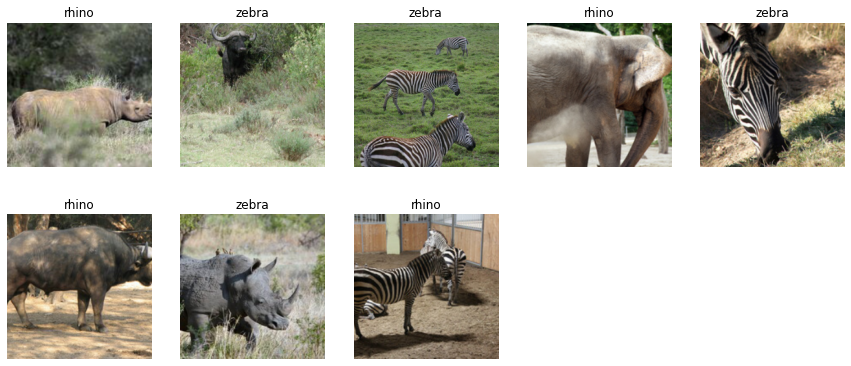

In [17]:
print("The predicted logits")
print(output)
predicted_labels = torch.argmax(output, dim=1)
print("The predicted classes")
print(predicted_labels)
plot_some_images(input.numpy(), predicted_labels, lazyDatasetTransform.get_all_class_names())